# 1st_week_sales_pred_v003

In [73]:
import os
import sys
import gc
import itertools
import pickle
import pathlib
import datetime
from dateutil.relativedelta import relativedelta
from dotenv import load_dotenv
load_dotenv()
sys.path.append(os.getenv('UTILS_PATH'))

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

import line_notify

In [74]:
import builtins
import types

def imports():
    for name, val in globals().items():
        # module imports
        if isinstance(val, types.ModuleType):
            yield name, val

            # functions / callables
        if hasattr(val, '__call__'):
            yield name, val


def noglobal(f):
    '''
    ref: https://gist.github.com/raven38/4e4c3c7a179283c441f575d6e375510c
    '''
    return types.FunctionType(f.__code__,
                              dict(imports()),
                              f.__name__,
                              f.__defaults__,
                              f.__closure__
                              )

In [75]:
SEED = 42
FOLD_N = 5

ディレクトリ設定

In [76]:
INPUT_DIR = os.getenv('INPUT_DIR')
OUTPUT_DIR = os.getenv('OUTPUT_DIR')
#exp_name = os.path.dirname(__file__).split('/')[-1]
exp_name = '1st_week_sales_pred_v003'
os.makedirs(OUTPUT_DIR + exp_name, exist_ok=True)

データ読み込み

In [77]:
articles = pd.read_csv(INPUT_DIR + 'articles.csv', dtype='object')
#customers = pd.read_csv(INPUT_DIR + 'customers.csv')
transactions = pd.read_csv(INPUT_DIR + 'transactions_train.csv', dtype={'article_id':'str'}, parse_dates=['t_dat'])
#sample = pd.read_csv(INPUT_DIR + 'sample_submission.csv')

In [78]:
# label_encoding
le_cols = ['product_type_name', 'product_group_name', 'graphical_appearance_name',
            'colour_group_name', 'perceived_colour_value_name', 'perceived_colour_master_name', 'department_name',
            'index_name', 'index_group_name', 'section_name', 'garment_group_name']
for c in le_cols:
    le = LabelEncoder()
    articles[c] = le.fit_transform(articles[c].fillna(''))

In [79]:
# detail_desc特徴量
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

n_dim = 100
text_col = 'detail_desc'
articles[text_col] = articles[text_col].str.lower()
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), stop_words='english')
text_tfidf = tfidf_vec.fit_transform(articles[text_col].fillna('').values.tolist())
svd = TruncatedSVD(n_components=n_dim, algorithm='arpack',random_state=42)

text_svd = svd.fit_transform(text_tfidf)
text_svd_df = pd.DataFrame(text_svd, columns=[f'{text_col}_svd_{i}' for i in range(n_dim)])
articles = pd.concat([articles, text_svd_df], axis=1)

In [80]:
transactions['1st_tran_dat'] = transactions.groupby('article_id')['t_dat'].transform('min')
transactions['1st_tran_dat_diff'] = (transactions['t_dat'] - transactions['1st_tran_dat']).dt.days
transactions2 = transactions[(transactions['1st_tran_dat'] > '2019-09-20') & (transactions['1st_tran_dat_diff'] <= 7)].copy()
transactions2 = transactions.reset_index(drop=True)

In [81]:
train = transactions2.groupby('article_id').agg({'t_dat':'count', '1st_tran_dat':'min'}).reset_index()
train.columns = ['article_id', '1st_week_sales', '1st_week_sales_dat']
train = train.merge(articles, on='article_id', how='left')

In [82]:
test = articles[~articles['article_id'].isin(transactions['article_id'].unique().tolist())].copy()
test['1st_week_sales_dat'] = datetime.datetime(2020,9,23)

# modeling

In [83]:
params = {
    "objective": "mae",
    "boosting" : "gbdt",
    "learning_rate": 0.1,
    "metric": "mae",
    "seed": SEED
}

In [84]:
target = '1st_week_sales'
features = ['product_type_name', 'product_group_name', 'graphical_appearance_name',
            'colour_group_name', 'perceived_colour_value_name', 'perceived_colour_master_name', 'department_name',
            'index_name', 'index_group_name', 'section_name', 'garment_group_name']
features = features + [f'detail_desc_svd_{i}' for i in range(n_dim)]

In [85]:
fi = pd.DataFrame()
oof = train[['article_id', '1st_week_sales_dat', '1st_week_sales']].copy()
oof['1st_week_sales_pred'] = np.nan
preds = np.zeros(len(test))
cv_scores = []

kf = KFold(n_splits=FOLD_N, random_state=SEED, shuffle=True)
for n, (tr_idx, vl_idx) in enumerate(kf.split(train)):

    print(f'fold{n} ' + '--'*10)
    tr_x, tr_y = train.iloc[tr_idx][features], train.iloc[tr_idx][target]
    vl_x, vl_y = train.iloc[vl_idx][features], train.iloc[vl_idx][target]
    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)

    model = lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                      num_boost_round=20000, early_stopping_rounds=100,verbose_eval=1000)

    fi_tmp = pd.DataFrame()
    fi_tmp['feature'] = model.feature_name()
    fi_tmp['importance'] = model.feature_importance(importance_type='gain')
    fi_tmp['fold'] = n
    fi = fi.append(fi_tmp)

    vl_pred = model.predict(vl_x, num_iteration=model.best_iteration)
    oof.loc[vl_idx, '1st_week_sales_pred'] = vl_pred

    pred = model.predict(test[features], num_iteration=model.best_iteration)
    preds += pred / FOLD_N

    cv_score = mean_squared_error(vl_y, vl_pred, squared=False)
    cv_scores.append(cv_score)
    print(f'fold{n} RMSE: ' + '{:.5f}'.format(cv_score))

test['1st_week_sales_pred'] = pred
print(f'CV SCORE: ' + '{:.5f}'.format(np.mean(cv_scores)))

fold0 --------------------


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26071
[LightGBM] [Info] Number of data points in the train set: 83637, number of used features: 111
[LightGBM] [Info] Start training from score 64.000000
Training until validation scores don't improve for 100 rounds
[1000]	training's l1: 197.216	valid_1's l1: 220.244
[2000]	training's l1: 184.191	valid_1's l1: 215.958
[3000]	training's l1: 174.45	valid_1's l1: 213.997
[4000]	training's l1: 169.291	valid_1's l1: 212.77
Early stopping, best iteration is:
[4688]	training's l1: 166.073	valid_1's l1: 212.042
fold0 RMSE: 652.31942
fold1 --------------------


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26068
[LightGBM] [Info] Number of data points in the train set: 83637, number of used features: 111
[LightGBM] [Info] Start training from score 65.000000
Training until validation scores don't improve for 100 rounds
[1000]	training's l1: 199.449	valid_1's l1: 213.171
[2000]	training's l1: 186.465	valid_1's l1: 209.395
[3000]	training's l1: 177.117	valid_1's l1: 206.963
[4000]	training's l1: 171.917	valid_1's l1: 205.651
Early stopping, best iteration is:
[4751]	training's l1: 168.768	valid_1's l1: 205.064
fold1 RMSE: 629.04407
fold2 --------------------


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26071
[LightGBM] [Info] Number of data points in the train set: 83638, number of used features: 111
[LightGBM] [Info] Start training from score 65.000000
Training until validation scores don't improve for 100 rounds
[1000]	training's l1: 195.26	valid_1's l1: 216.882
[2000]	training's l1: 182.486	valid_1's l1: 213.195
[3000]	training's l1: 175.273	valid_1's l1: 211.225
[4000]	training's l1: 169.824	valid_1's l1: 210.208
[5000]	training's l1: 166.017	valid_1's l1: 209.509
[6000]	training's l1: 162.776	valid_1's l1: 208.704
Early stopping, best iteration is:
[6598]	training's l1: 161.184	valid_1's l1: 208.434
fold2 RMSE: 669.64226
fold3 --------------------


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26067
[LightGBM] [Info] Number of data points in the train set: 83638, number of used features: 111
[LightGBM] [Info] Start training from score 65.000000
Training until validation scores don't improve for 100 rounds
[1000]	training's l1: 195.044	valid_1's l1: 227.037
[2000]	training's l1: 182.444	valid_1's l1: 223.142
Early stopping, best iteration is:
[2600]	training's l1: 177.022	valid_1's l1: 221.403
fold3 RMSE: 844.38975
fold4 --------------------


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26069
[LightGBM] [Info] Number of data points in the train set: 83638, number of used features: 111
[LightGBM] [Info] Start training from score 65.000000
Training until validation scores don't improve for 100 rounds
[1000]	training's l1: 197.953	valid_1's l1: 216.367
[2000]	training's l1: 184.647	valid_1's l1: 212.81
[3000]	training's l1: 175.667	valid_1's l1: 210.86
Early stopping, best iteration is:
[3840]	training's l1: 171.338	valid_1's l1: 209.871
fold4 RMSE: 657.14244
CV SCORE: 690.50759


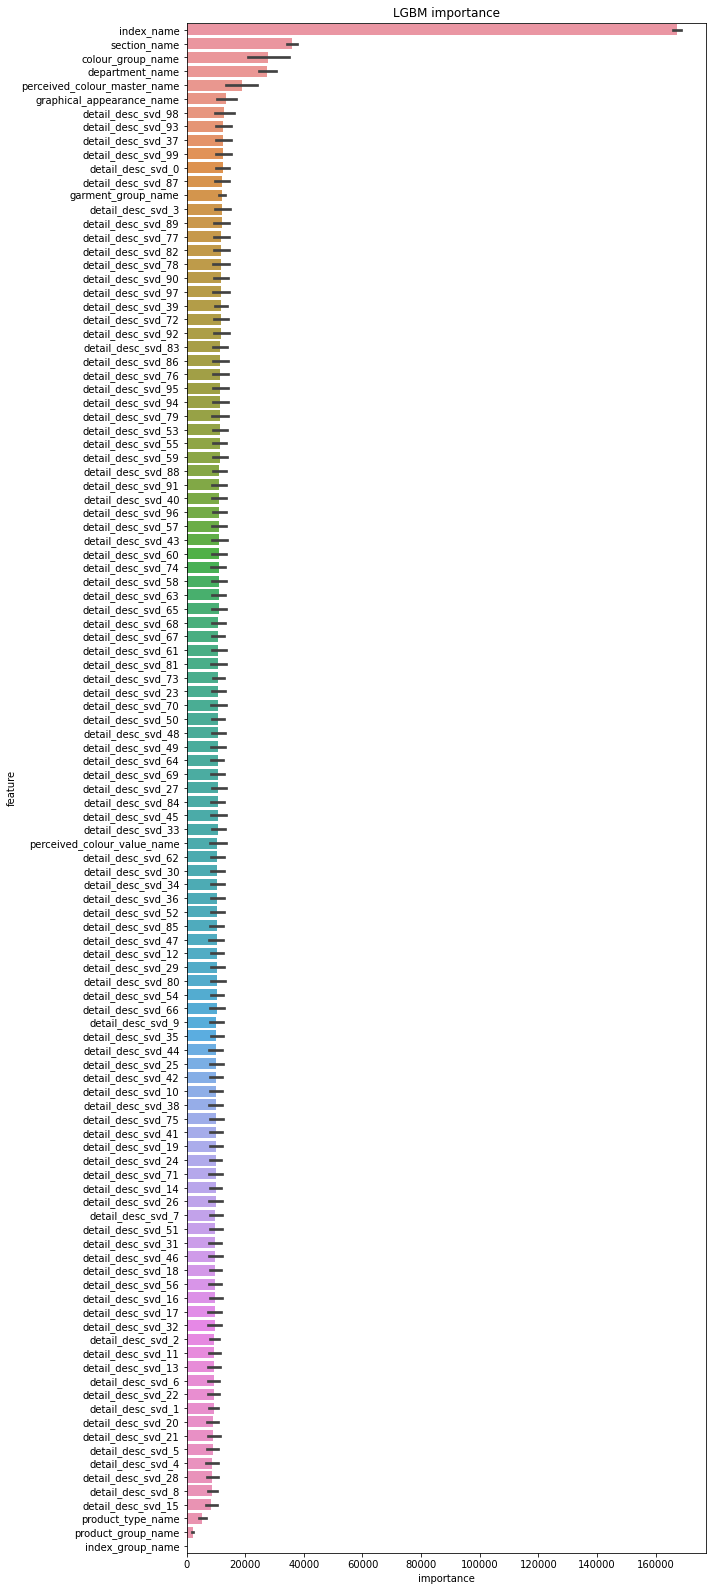

In [86]:
fi_n = fi['feature'].nunique()
order = list(fi.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, fi_n*0.2))
sns.barplot(x="importance", y="feature", data=fi, order=order)
plt.title(f"LGBM importance")
plt.tight_layout()
plt.savefig(OUTPUT_DIR + f'{exp_name}/lgbm_importance.png')

結果

In [87]:
print('RMSE : ', '{:.5f}'.format(mean_squared_error(oof['1st_week_sales'], oof['1st_week_sales_pred'], squared=False)))
print('MAE  : ', '{:.5f}'.format(mean_absolute_error(oof['1st_week_sales'], oof['1st_week_sales_pred'])))
print('相関係数  : ', '{:.5f}'.format(oof[['1st_week_sales', '1st_week_sales_pred']].corr().iat[0,1]))
print('順位相関  : ', '{:.5f}'.format(oof[['1st_week_sales', '1st_week_sales_pred']].corr(method='spearman').iat[0,1]))

RMSE :  694.90447
MAE  :  211.36294
相関係数  :  0.52846
順位相関  :  0.69796


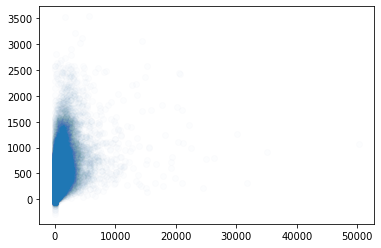

In [88]:
plt.scatter(oof['1st_week_sales'], oof['1st_week_sales_pred'], alpha=0.01)

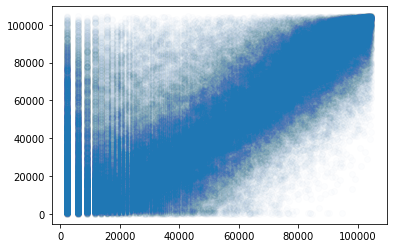

In [89]:
plt.scatter(oof['1st_week_sales'].rank(), oof['1st_week_sales_pred'].rank(), alpha=0.01)

In [90]:
usecols = ['article_id', '1st_week_sales_dat', '1st_week_sales_pred']
result = pd.concat([oof[usecols], test[usecols]])
result.to_csv(OUTPUT_DIR + f'{exp_name}/result.csv', index=False)
result

,article_id,1st_week_sales_dat,1st_week_sales_pred
0,0108775015,2018-09-20,811.802526
1,0108775044,2018-09-20,635.103003
2,0108775051,2018-09-20,1610.418112
3,0110065001,2018-09-20,374.993638
4,0110065002,2018-09-20,503.729761
...,...,...,...
105529,0949323002,2020-09-23,213.413764
105533,0950449002,2020-09-23,22.425339
105535,0952937003,2020-09-23,140.976409
105540,0957375001,2020-09-23,77.875065
